In [5]:
import pandas as pd

# Load the data from the CSV file
btc_data = pd.read_csv('Bitcoin Historical Data.csv')

# Ensure the data is sorted by date if not already
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data = btc_data.sort_values(by='Date')

# Calculate the 4-day and 7-day moving averages
btc_data['4MA'] = btc_data['Price'].rolling(window=4).mean()
btc_data['7MA'] = btc_data['Price'].rolling(window=7).mean()

# Display the updated DataFrame
btc_data.head(10)

,Date,Price,Open,High,Low,Vol. ('000),Change %,4MA,7MA
4111,2014-01-01,815.9,805.9,829.9,771.0,10.76,1.24%,NaN,NaN
4110,2014-01-02,856.9,815.9,886.2,810.5,12.81,5.02%,NaN,NaN
4109,2014-01-03,884.3,856.9,888.2,839.4,9.71,3.19%,NaN,NaN
4108,2014-01-04,924.7,884.3,932.2,848.3,14.24,4.57%,870.450,NaN
4107,2014-01-05,1014.7,924.7,1029.9,911.4,21.37,9.74%,920.150,NaN
4106,2014-01-06,1012.7,1014.7,1093.4,964.7,23.08,-0.21%,959.100,NaN
4105,2014-01-07,879.9,1012.7,1044.0,879.8,22.67,-13.11%,958.000,912.728571
4104,2014-01-08,938.8,879.9,966.9,858.9,14.1,6.70%,961.525,930.285714
4103,2014-01-09,937.0,938.8,964.6,866.5,14.42,-0.20%,942.100,941.728571
4102,2014-01-10,957.8,937.0,964.8,905.9,6.35,2.22%,928.375,952.228571


In [45]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Define a quadratic function for curve fitting
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Function to check for an upside trend before the cup
def has_upside_trend(prices, idx, lookback=3, min_increase=0.50):
    if idx < lookback:
        return False  # Not enough data for the lookback period
    recent_prices = prices[idx - lookback:idx]
    avg_increase = (recent_prices[-1] - recent_prices[0]) / recent_prices[0]
    return avg_increase >= min_increase

# Function to check for a valid cup formation with enhanced mathematical validation
def is_valid_cup(prices, tolerance=0.01, min_drop=0.05, max_edge_diff=0.02, min_curvature=0.0001, symmetry_tolerance=0.1):
    x = np.arange(len(prices))  # X-axis values (time indices)
    left_edge = prices[0]  # Left edge of the cup
    right_edge = prices[-1]  # Right edge of the cup
    bottom = min(prices)  # Bottom of the cup
    bottom_idx = np.argmin(prices)  # Index of the bottom

    # Ensure the bottom is at least `min_drop` lower than both edges
    if bottom >= left_edge * (1 - min_drop) or bottom >= right_edge * (1 - min_drop):
        return False

    # Ensure the left and right edges are within `tolerance` of each other
    if abs(left_edge - right_edge) / left_edge > tolerance:
        return False

    # Ensure the absolute difference between left and right edges is within `max_edge_diff`
    if abs(left_edge - right_edge) > max_edge_diff * left_edge:
        return False

    # Fit a quadratic curve to the prices
    try:
        params, _ = curve_fit(quadratic, x, prices)
        a, b, c = params

        # Check if the curve is a U-shape (a > 0)
        if a <= 0:
            return False

        # Check if the curvature is steep enough
        if a < min_curvature:
            return False

        # Check if the minimum point of the quadratic curve aligns with the bottom
        min_idx = -b / (2 * a)
        if abs(min_idx - bottom_idx) > len(prices) * 0.05:  # Allow a 5% deviation
            return False

        # Check for symmetry: Compare the left and right halves of the cup
        left_half = prices[:bottom_idx]
        right_half = prices[bottom_idx + 1:]
        if len(left_half) != len(right_half):  # Ensure equal lengths for comparison
            return False
        symmetry_diff = np.mean(np.abs(left_half[::-1] - right_half) / left_half[::-1])
        if symmetry_diff > symmetry_tolerance:
            return False

        # Check depth-to-width ratio
        cup_width = len(prices)
        cup_depth = max(left_edge, right_edge) - bottom
        if cup_depth / cup_width < 0.1:  # Ensure the depth is at least 10% of the width
            return False

    except Exception as e:
        print(f"Curve fitting failed: {e}")
        return False

    # Fit a quadratic curve to the prices
    try:
        params, _ = curve_fit(quadratic, x, prices)
        a, b, c = params

        # Check if the curve is a U-shape (a > 0)
        if a <= 0:
            return False

        # Check if the minimum point of the quadratic curve aligns with the bottom
        min_idx = -b / (2 * a)
        if abs(min_idx - bottom_idx) > len(prices) * 0.05:  # Allow a 5% deviation
            return False
    except:
        return False

    return True

# Function to check for a valid handle formation
# Function to check for a valid handle formation with enhanced validation
def is_valid_handle(prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30, max_slope=-0.001):
    handle_start = prices[0]
    handle_end = prices[-1]
    handle_drop = handle_start - handle_end
    required_drop = min_drop_ratio * (cup_height - cup_bottom)

    # Ensure the handle lasts at least `min_days` and drops by the required amount
    if len(prices) < min_days or handle_drop < required_drop:
        return False

    # Ensure the handle is a clear downward trend
    if not all(prices[i] >= prices[i + 1] for i in range(len(prices) - 1)):
        return False

    # Calculate the slope of the handle
    x = np.arange(len(prices))
    slope, intercept = np.polyfit(x, prices, 1)  # Fit a linear trend line

    # Ensure the slope is negative and steep enough
    if slope >= 0 or slope > max_slope:
        return False

    return True

# Function to check for a breakthrough after the handle
def has_breakthrough(prices, handle_end_idx):
    if handle_end_idx + 1 >= len(prices):
        return False  # Not enough data for breakthrough check
    handle_prices = prices[:handle_end_idx + 1]
    handle_slope = (handle_prices[-1] - handle_prices[0]) / len(handle_prices)

    # Check if the price breaks above the downward slope of the handle
    for i in range(handle_end_idx + 1, len(prices)):
        if prices[i] > handle_prices[-1] + handle_slope * (i - handle_end_idx):
            return True
    return False

btc_data["7MA"] = btc_data["Price"].rolling(window=7).mean()

# Detect cup and handle patterns in the price data
btc_data["Cup_Formation"] = 0
btc_data["Handle_Formation"] = 0
btc_data["Breakthrough"] = 0
btc_data["Cup_Start"] = np.nan
btc_data["Cup_End"] = np.nan
prices = btc_data["4MA"].values

for idx in range(len(btc_data) - 60):  # Ensure enough data for a 30-day window
    for period in range(14, 60):  # Check for periods between 14 and 60 days
        if idx + period < len(btc_data):
            cup_prices = prices[idx:idx + period]
            if has_upside_trend(prices, idx, lookback=5, min_increase=0.05) and is_valid_cup(cup_prices, tolerance=0.1, min_drop=0.10):
                cup_bottom = min(cup_prices)
                cup_height = max(cup_prices[0], cup_prices[-1])
                btc_data.loc[idx + period - 1, "Cup_Formation"] = 1  # Mark the rightmost position of the cup
                btc_data.loc[idx + 7, "Cup_Start"] = 1  # Mark the starting point of the cup
                btc_data.loc[idx + period - 1, "Cup_End"] = 1  # Mark the ending point of the cup

                # Check for handle formation
                handle_start_idx = idx + period
                for handle_period in range(7, 15):  # Check for handle periods between 7 and 15 days
                    if handle_start_idx + handle_period < len(btc_data):
                        handle_prices = prices[handle_start_idx:handle_start_idx + handle_period]
                        if is_valid_handle(handle_prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30):
                            btc_data.loc[handle_start_idx + handle_period - 1, "Handle_Formation"] = 1

                            # Check and mark for breakthrough
                            if has_breakthrough(prices, handle_start_idx + handle_period - 1):
                                btc_data.loc[handle_start_idx + handle_period - 1, "Breakthrough"] = 1
                            break

In [46]:
# number of cup start and end points detected
cup_start_points = btc_data["Cup_Start"].sum()
cup_end_points = btc_data["Cup_End"].sum()
print(f"Number of cup start points detected: {cup_start_points}")
print(f"Number of cup end points detected: {cup_end_points}")

# number of patterns detected
patterns_detected = btc_data["Cup_Formation"].sum()
print(f"Number of cup and handle patterns detected: {patterns_detected}")

# number of breakthroughs detected
breakthroughs_detected = btc_data["Breakthrough"].sum()
print(f"Number of breakthroughs detected: {breakthroughs_detected}")

Number of cup start points detected: 7.0
Number of cup end points detected: 7.0
Number of cup and handle patterns detected: 7
Number of breakthroughs detected: 0


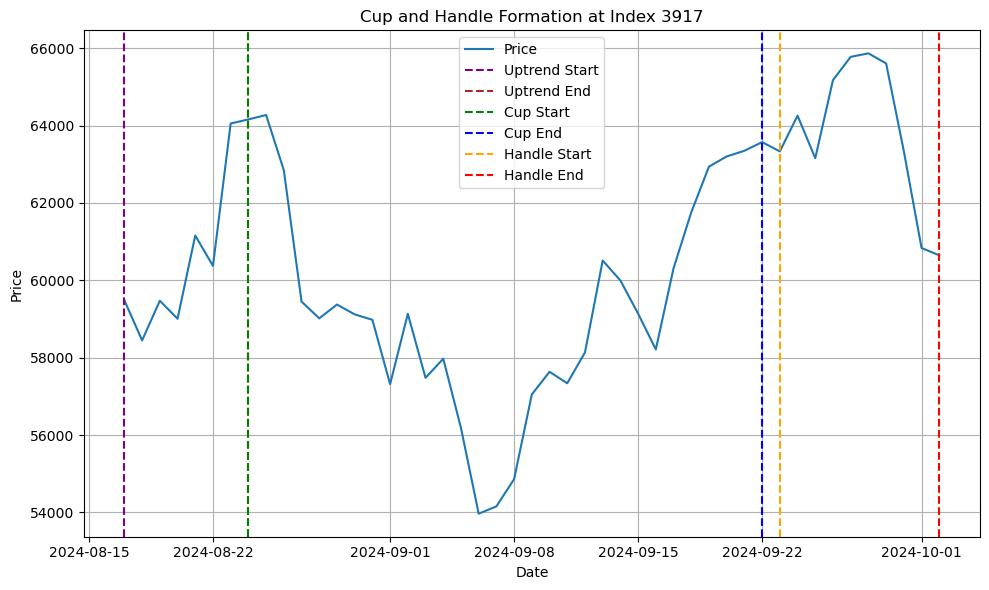

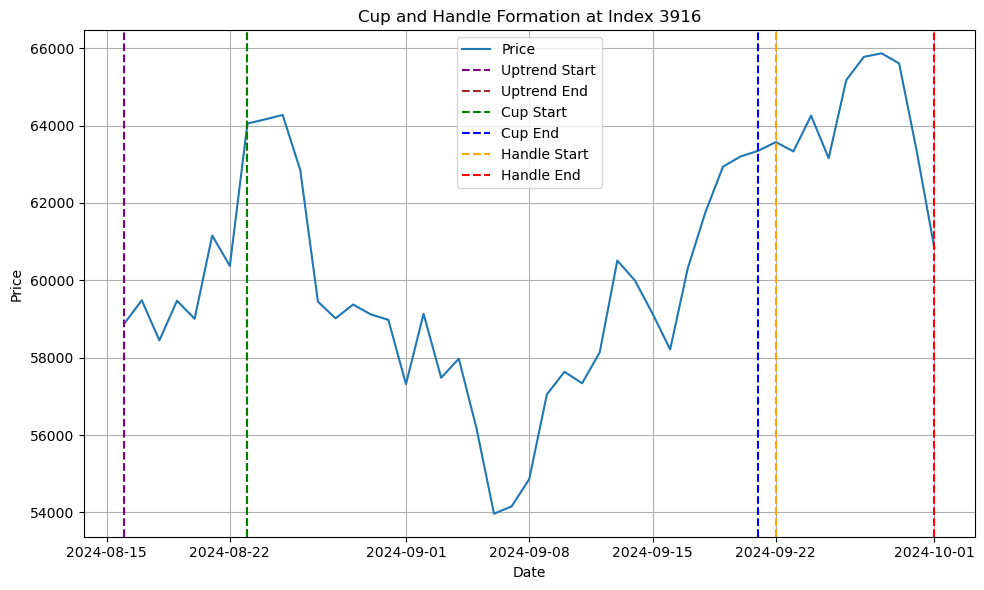

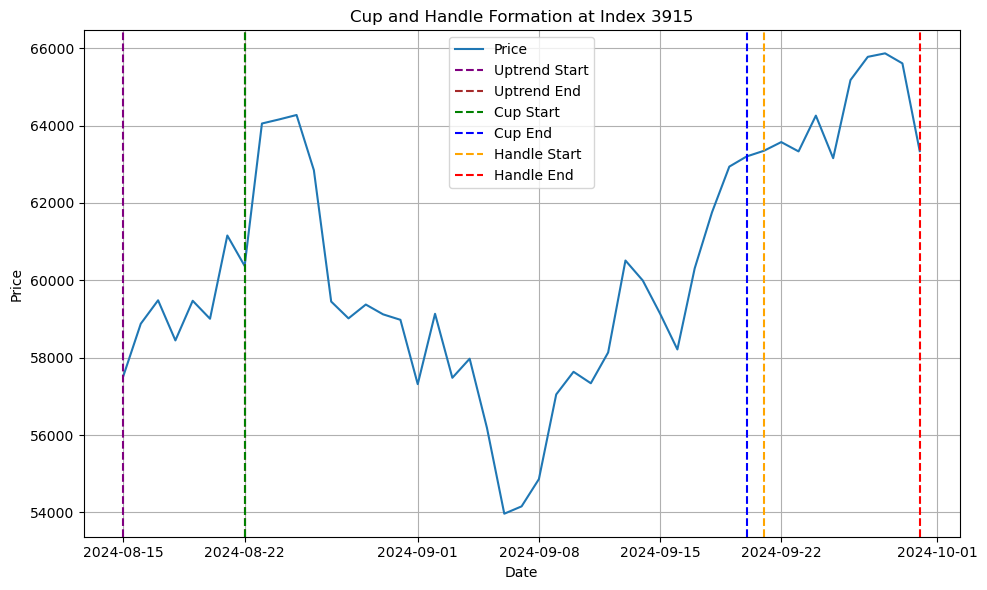

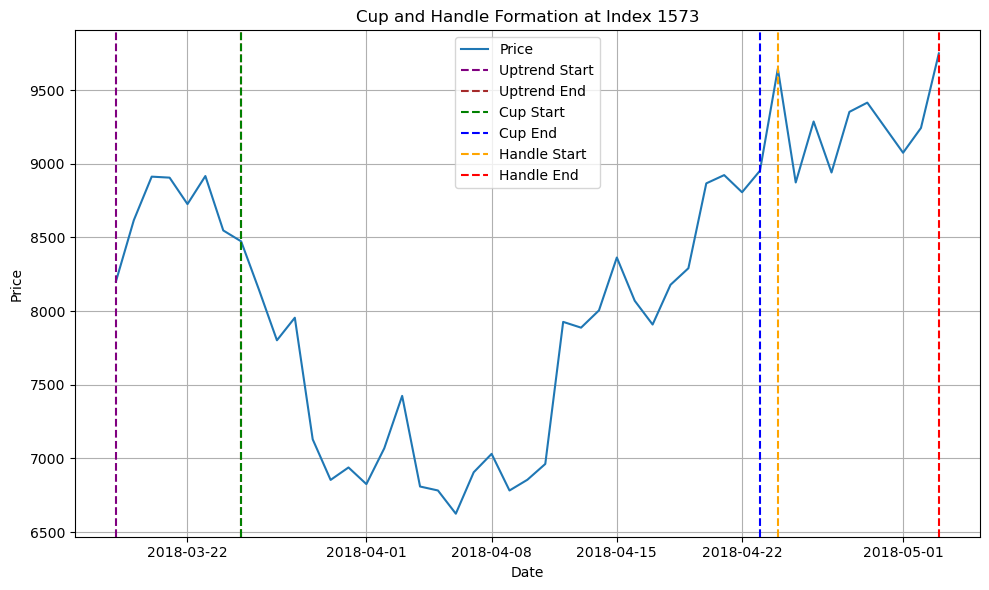

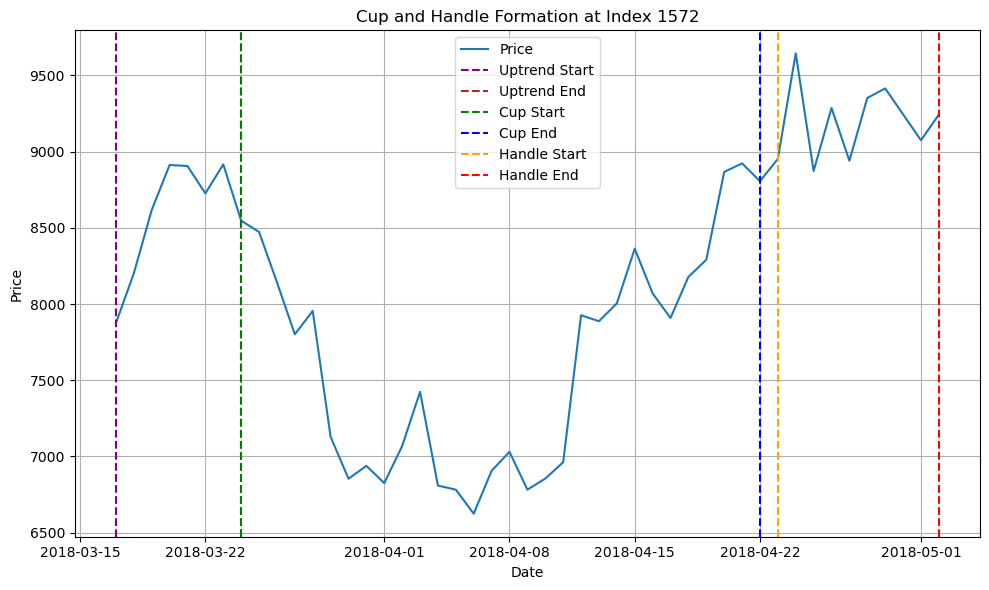

In [47]:
# Plot the first 5 cup and handle formations
import matplotlib.pyplot as plt

# Filter the rows where a cup formation is detected
cup_indices = btc_data[btc_data["Cup_Formation"] == 1].index[:5]

# Define period and handle_period for plotting
period = 30  # Example value, adjust as needed
handle_period = 10  # Example value, adjust as needed
lookback = 7  # Lookback period for uptrend detection

# Plot the first 5 cup and handle formations
for idx in cup_indices:
    start_idx = idx - period + 1  # Start of the cup
    end_idx = idx  # End of the cup
    handle_start_idx = idx + 1  # Start of the handle
    handle_end_idx = handle_start_idx + handle_period - 1  # End of the handle
    uptrend_start_idx = start_idx - lookback  # Start of the uptrend
    uptrend_end_idx = start_idx  # End of the uptrend (start of the cup)

    # Validate indices
    if uptrend_start_idx < 0 or handle_end_idx >= len(btc_data):
        continue

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(
        btc_data["Date"].iloc[uptrend_start_idx:handle_end_idx + 1],
        btc_data["Price"].iloc[uptrend_start_idx:handle_end_idx + 1],
        label="Price"
    )
    plt.axvline(btc_data["Date"].iloc[uptrend_start_idx], color="purple", linestyle="--", label="Uptrend Start")
    plt.axvline(btc_data["Date"].iloc[uptrend_end_idx], color="brown", linestyle="--", label="Uptrend End")
    plt.axvline(btc_data["Date"].iloc[start_idx], color="green", linestyle="--", label="Cup Start")
    plt.axvline(btc_data["Date"].iloc[end_idx], color="blue", linestyle="--", label="Cup End")
    plt.axvline(btc_data["Date"].iloc[handle_start_idx], color="orange", linestyle="--", label="Handle Start")
    plt.axvline(btc_data["Date"].iloc[handle_end_idx], color="red", linestyle="--", label="Handle End")
    plt.title(f"Cup and Handle Formation at Index {idx}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()